In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from dynamics_env.dynamics_ma import Dynamics
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15
import pandas as pd

In [2]:
file_name = 'two_body_2'

In [3]:
results_file = f'runs/Dynamics-v0__{file_name}_best_performers.csv'

In [4]:
init_params = [0.48813504, 2.15189366, 1.02763376, 2.69299098, 4.58071204, 8.75364678]
device = torch.device('cuda' if torch.cuda.is_available and False else 'cpu')
seed = 0
M = 10
orbit_timesteps = 1000
orbit_duration = 10000 # Myr

In [5]:
def make_env(seed):
        def thunk():
            env = Dynamics(hyperparameters={
                'stationary_potential_list':['bar'],
                'stationary_potential_kwargs_list':[{'M':1e10, 'a':5000, 'b':1500, 'c':1000, 'omega_p':0.04}],
                'dynamic_potential_list':['point_source','point_source'],
                'dynamic_potential_kwargs_list':[{'M':1e4}, {'M':1e4}],
                'seed':seed,
                'box_scaling':1000,
            })
            env.action_space.seed(seed)
            env.observation_space.seed(seed)
            return env
        return thunk
env = make_env(seed=seed)()
env.reset()
def plot_from_init(init_params):
    env.reset()
    _, reward, _, _, info = env.step(init_params)
    orbit = info['orbit']
    orbit_delta = info['orbit_delta']
    reverse_orbit_init_params = orbit.y[:,-1]
    reverse_orbit_delta_init_params = orbit_delta.y[:,-1]
    reverse_orbit = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    reverse_orbit_delta = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_delta_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    fig = plt.figure(figsize=(30, 10))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    for agent in range(env.num_agents):
        ax1.plot(orbit.y[agent*6], orbit.y[agent*6+1], orbit.y[agent*6+2], lw=0.5, label=r'$O_%d$'%agent)
        ax1.plot(orbit_delta.y[agent*6], orbit_delta.y[agent*6+1], orbit_delta.y[agent*6+2], lw=0.5, label=r'$O_{\delta%d}$'%agent)
        ax1.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], orbit.y[agent*6+2][0], label='Trajectory %d start'%agent)
    ax2 = fig.add_subplot(132)
    
    # ax2.scatter(0, 0, label='Source')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Projected Orbit')
    for agent in range(env.num_agents):
        ax2.plot(orbit.y[agent*6+0], orbit.y[agent*6+1], lw=2, label=r'$O_%d$'%agent)
        ax2.plot(orbit_delta.y[agent*6+0], orbit_delta.y[agent*6+1], lw=2, label=r'$O_{\delta%d}$'%agent)
        ax2.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], label='Trajectory %d start'%agent)
    ax1.set_title(f'3D Orbit')

    ax3 = fig.add_subplot(133)
    ax3.plot((orbit.y-reverse_orbit.y).sum(axis=0))
    ax3.set_title(f'Orbit-reverse-orbit distances: {(orbit.y - reverse_orbit.y).sum()}')
        
    print(reward)
    print(init_params)
    ax1.legend()
    ax2.legend()
    # ax3.legend()

[ENV] Using cpu
[ENV] Seed set to 0


In [6]:
# results = pd.read_csv(results_file).sort_values(by=['reward'], ascending=False)
# result_init_params = {i:results.iloc[:, [j for j in range(i * 6+1, (i+1) * 6 + 1)]].to_numpy().transpose() for i in range(env.num_agents)}
# result_init_params['reward'] = results.loc[:,'reward'].to_numpy()
# fig = plt.figure(figsize=(16, 8))
# ax1 = fig.add_subplot(121, projection='3d')
# for agent in range(env.num_agents):
#     ax1.scatter(result_init_params[agent][0], result_init_params[agent][1], result_init_params[agent][2], label='%d'%agent)
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')
# ax1.set_zlabel('Z')
# ax1.legend()
# ax1.set_title('Initial positions studied')

# ax2 = fig.add_subplot(122)
# for agent in range(env.num_agents):
#     ax2.scatter(result_init_params[agent][0], result_init_params[agent][1], label='%d'%agent)
# ax2.set_xlabel('X')
# ax2.set_ylabel('Y')
# ax2.legend()
# ax2.set_title('Initial positions studied, projected on the XY plane')

Text(0.5, 0.92, 'Initial positions studied')

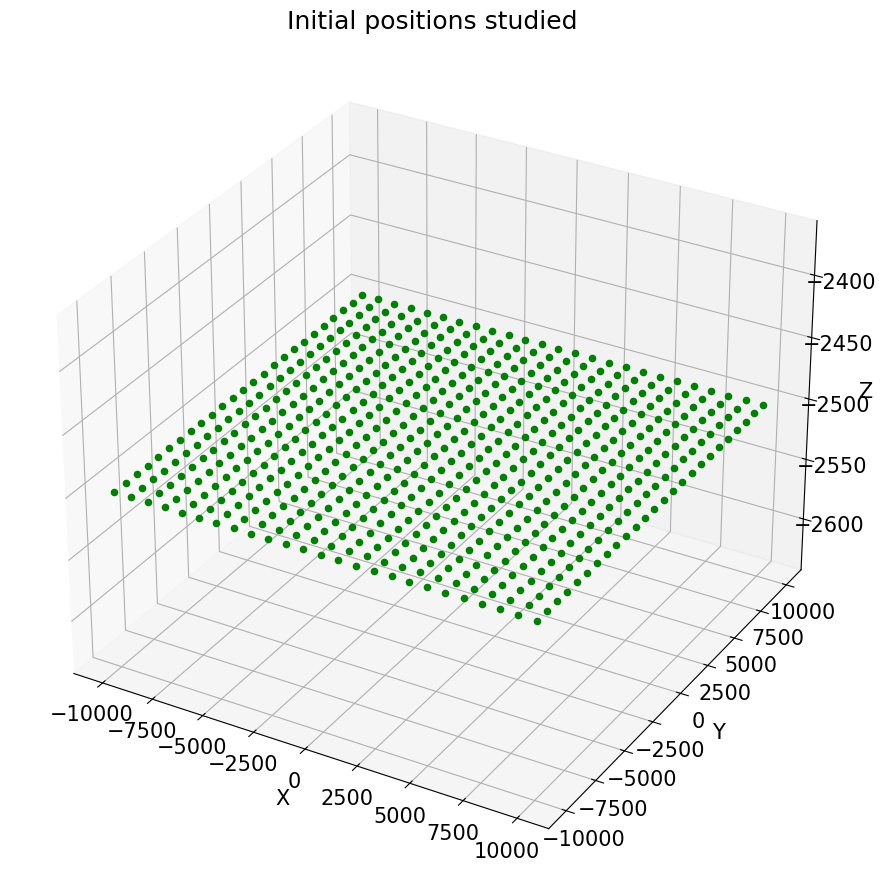

In [7]:
fig = plt.figure(figsize=(24, 12))
ax1 = fig.add_subplot(121, projection='3d')
X = np.linspace(-10000,10000,25)
x, y, z = np.meshgrid(X, X, X)
k=9
for i in range(len(x)):
    for j in range(len(x)):
        # for k in range(len(x)):
            inside_bar = env.stationary_potentials[0].get_acceleration(np.array([x[i][j][k],y[i][j][k],z[i][j][k],0]))[0] != 0
            c = 'b' if inside_bar else 'g'
            ax1.scatter(x[i][j][k],y[i][j][k],z[i][j][k],c=c)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Initial positions studied')

Text(0.5, 0.92, 'Initial positions studied')

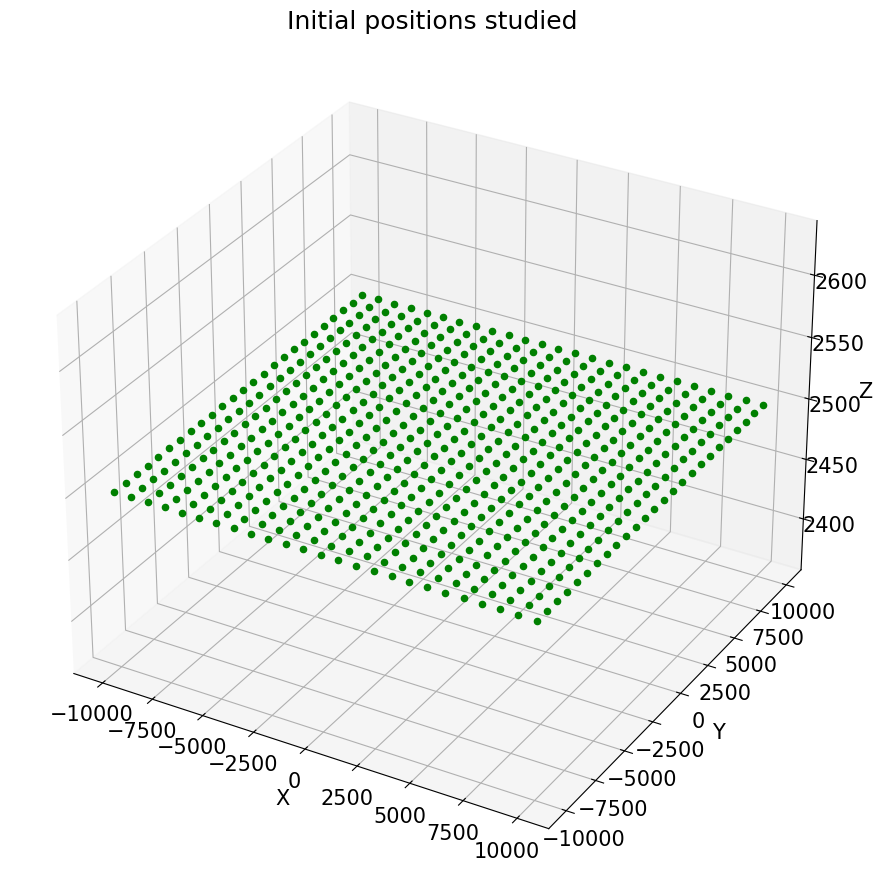

In [15]:
fig = plt.figure(figsize=(24, 12))
ax1 = fig.add_subplot(121, projection='3d')
X = np.linspace(-10000,10000,25)
x, y, z = np.meshgrid(X, X, X)
k=15
for i in range(len(x)):
    for j in range(len(x)):
        # for k in range(len(x)):
            inside_bar = env.stationary_potentials[0].get_acceleration(np.array([x[i][j][k],y[i][j][k],z[i][j][k],0]))[0] != 0
            c = 'b' if inside_bar else 'g'
            ax1.scatter(x[i][j][k],y[i][j][k],z[i][j][k],c=c)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Initial positions studied')

Text(0.5, 0.92, 'Initial positions studied')

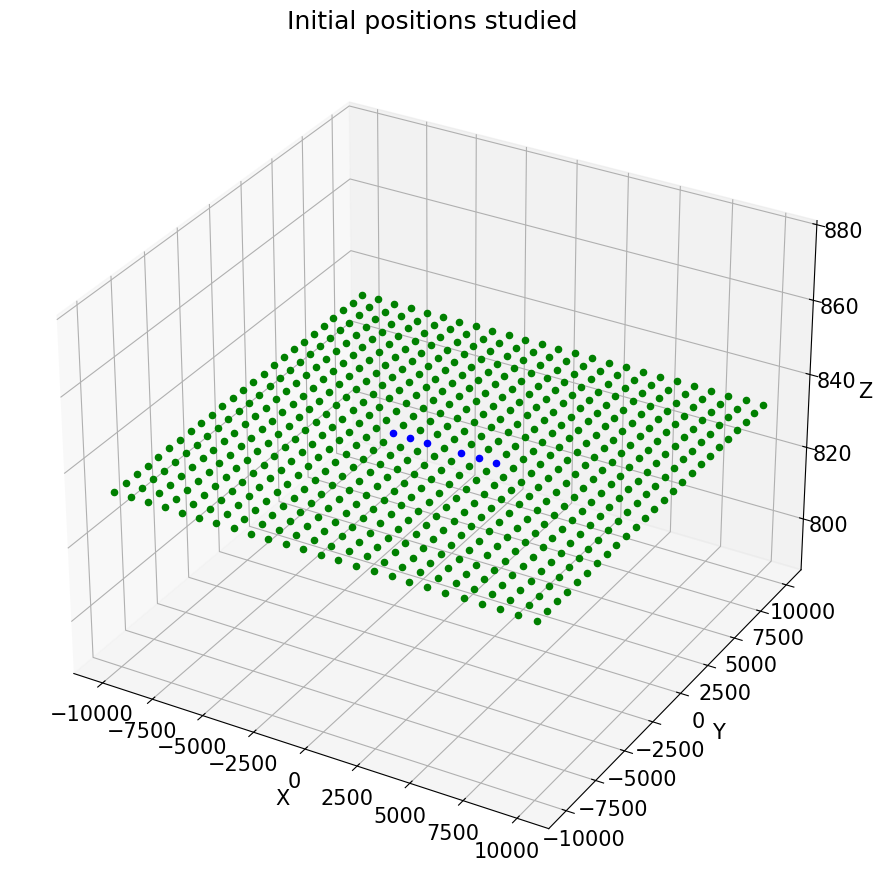

In [17]:
fig = plt.figure(figsize=(24, 12))
ax1 = fig.add_subplot(121, projection='3d')
X = np.linspace(-10000,10000,25)
x, y, z = np.meshgrid(X, X, X)
k=13
for i in range(len(x)):
    for j in range(len(x)):
        # for k in range(len(x)):
            inside_bar = env.stationary_potentials[0].get_acceleration(np.array([x[i][j][k],y[i][j][k],z[i][j][k],0]))[0] != 0
            c = 'b' if inside_bar else 'g'
            ax1.scatter(x[i][j][k],y[i][j][k],z[i][j][k],c=c)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Initial positions studied')

In [ ]:
fig = plt.figure(figsize=(24, 12))
ax1 = fig.add_subplot(121, projection='3d')
X = np.linspace(-10000,10000,25)
x, y, z = np.meshgrid(X, X, X)
k=12
for i in range(len(x)):
    for j in range(len(x)):
        # for k in range(len(x)):
            inside_bar = env.stationary_potentials[0].get_acceleration(np.array([x[i][j][k],y[i][j][k],z[i][j][k],0]))[0] != 0
            c = 'b' if inside_bar else 'g'
            ax1.scatter(x[i][j][k],y[i][j][k],z[i][j][k],c=c)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Initial positions studied')

In [9]:
print(env.stationary_potentials[0].get_acceleration(np.array([100,1,200,0])))
print(env.stationary_potentials[0].get_acceleration(np.array([100,1,200,0]))[0])
print(env.stationary_potentials[0].get_acceleration(np.array([100,1,200,0]))[0] != 0)

(array([-0.03440728]), array([-0.01274344]), array([-8.60182]))
[-0.03440728]
[ True]


In [10]:
# def result_to_init(i):
#     return {agent:result_init_params[agent][:,i] for agent in range(env.num_agents)}

{0: np.float64(0.00012200910734908792), 1: np.float64(0.00012195380685821837)}
{0: array([    0, 10000,     0,     0,     0,     0]), 1: array([     0, -10000,      0,      0,      0,      0])}


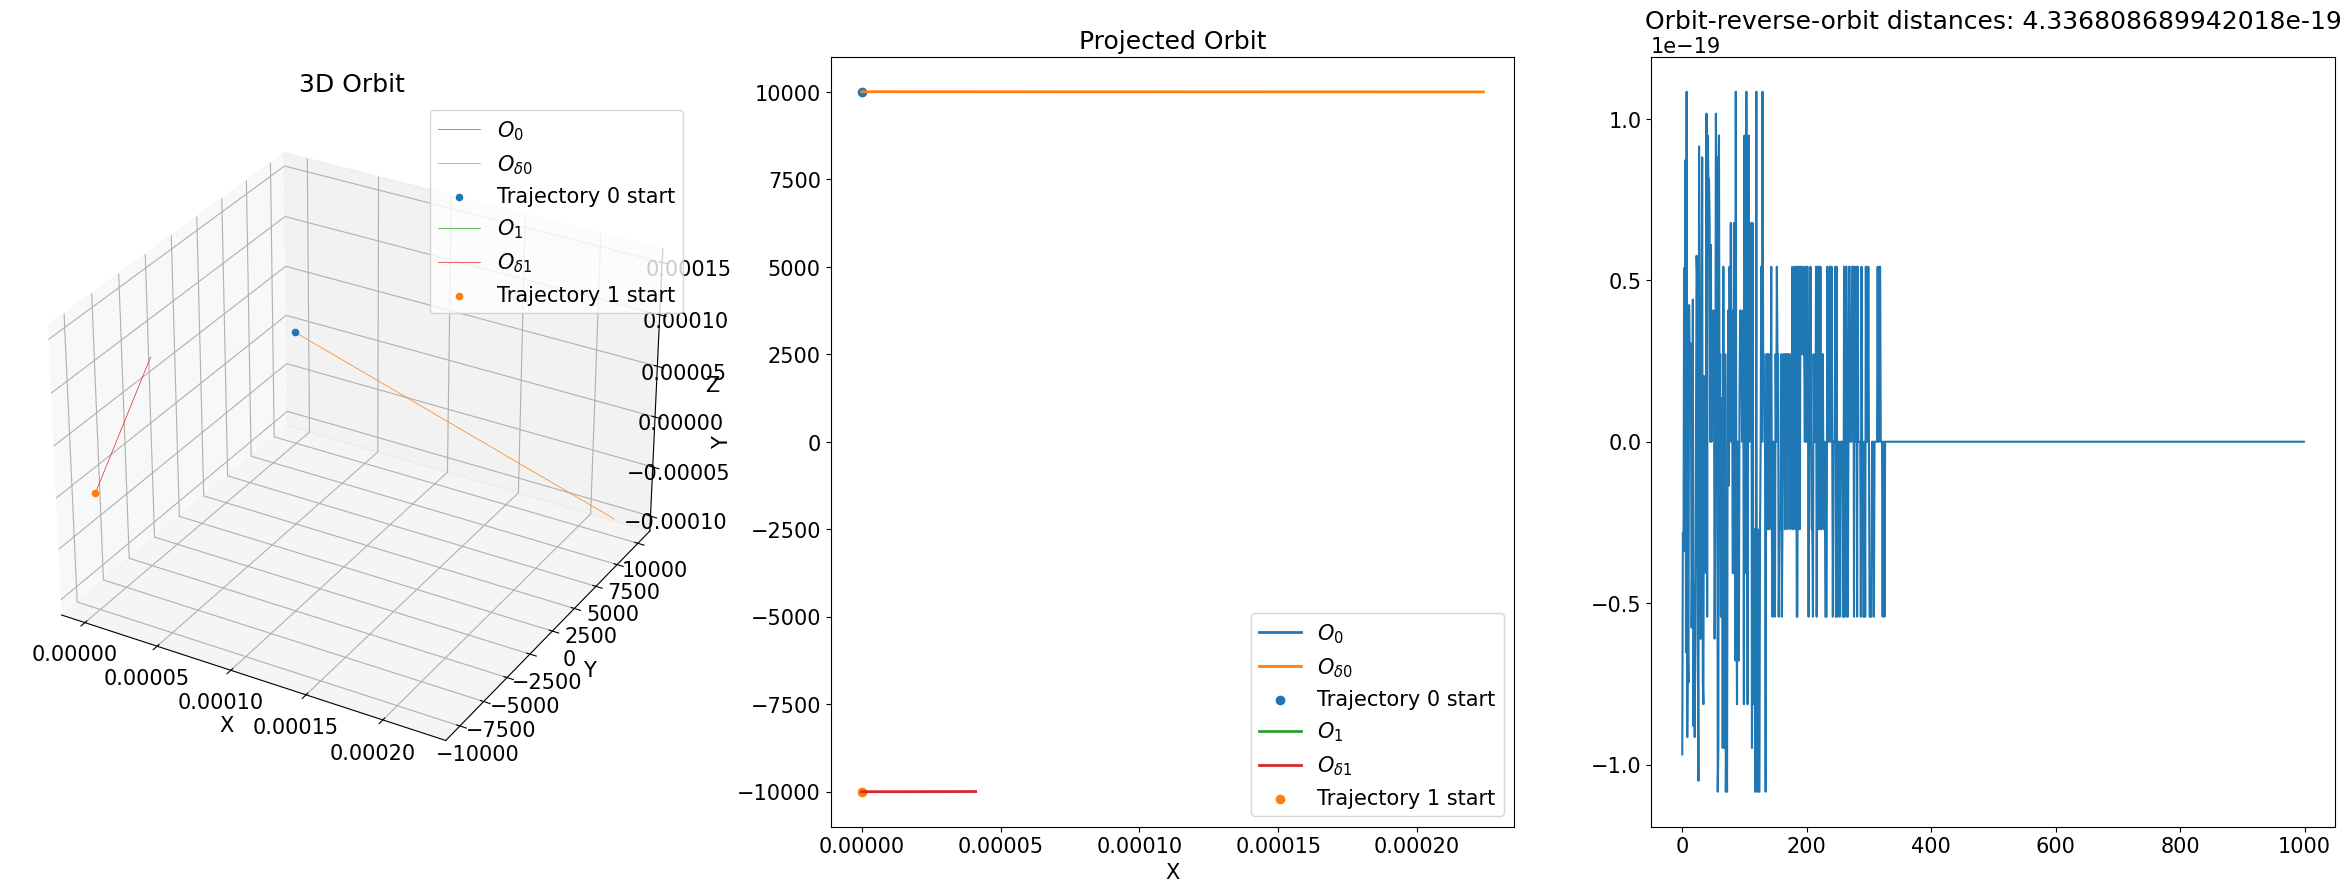

In [11]:
init_params = {0:np.array([0,10000,0,0,0,0]), 1:np.array([0,-10000,0,0,0,0])}
plot_from_init(init_params)

In [12]:
# plot_from_init(result_to_init(0))

In [13]:
# plot_from_init(result_to_init(1))

In [14]:
plot_from_init(result_to_init(2))

NameError: name 'result_to_init' is not defined

In [ ]:
plot_from_init(result_to_init(5))

In [ ]:
plot_from_init(result_to_init(-1))